# Tarea 2  - Aprendizaje de Máquinas Probabilístico
* Profesor: Felipe Tobar
* Auxiliares: Alejandro Cuevas y Alejandro Veragua

* Preguntas: Ucursos

# Descripción
* El objetivo de esta tarea es implementar una red neuronal feed-forward, para ello será necesario el uso de ** Tensorflow **.
* La tarea se dividirá en dos partes:
    - Realizar un tutorial de redes neuronales utilizando tensorflow y la base de datos de la tarea 1, P3.
    - Diseñar una arquitectura de red para la base de datos  [THE MNIST DATABASE of handwritten digits](http://yann.lecun.com/exdb/mnist/)   y obtener métricas de desempeño para su arquitectura.
* Entregue este mismo notebook de Python con sus desarrollos.

# Introducción a Redes Neuronales y Tensorflow
## Instalar Tensorflow
* Existen varias librerías desarrolladas en Python para implementar redes neuronales (Tensorflow, Keras, PyBrain, Scikit-learn, etc) y en otros lenguajes (C++, Matlab, R, etc). En esta tarea utilizaremos [Tensorflow](https://www.tensorflow.org/), para ello se requiere el utilizar Python >2.7 (Python 3.6 recomendado).
* Las instrucciones de instalación se encuentran detalladas en [Install Tensorflow (https://www.tensorflow.org/install/). Esta librería tiene soporte en Ubuntu, Windows y Mac OSX, y también es compatible con tarjetas gráficas NVIDIA, no obstante solo utilizaremos CPU.
    
    ** Nota** Si se encuentra en Windows, Tensorflow solo es compatible con python 3.5.x

* En el sitio web tambien podrá encontrar las instrucciones de instalación si utiliza en Anaconda.
* Verifiquemos si tensorflow quedó instalado correctamente (hasta ahora no sabemos qué es tensorflow):


In [1]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


## Cargar datos ( P3 - Tarea 1, Otoño 2017)


In [2]:
import numpy as np

data = np.genfromtxt('datosT1P3.txt',delimiter=',')
X = data[:2, :].astype(np.float32)
Y = data[2, :].astype(int)
zero_index = np.where(Y == 0)[0]
one_index = np.where(Y == 1)[0]
print('Dimension de los datos de entrada: ', X.shape)
print('Dimension de los dato de salida: ', Y.shape)

Dimension de los datos de entrada:  (2, 1000)
Dimension de los dato de salida:  (1000,)


* Ahora se separan los datos en dos conjuntos:
    * Entrenamiento ( 70 %)
    * Prueba (30 %)


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.T, Y, test_size=0.30)

print('Ejemplos de entrenamiento: %i' %X_train.shape[0])
print('Ejemplos de test: %i' %X_test.shape[0])


Ejemplos de entrenamiento: 700
Ejemplos de test: 300


** Grafique las muetras y verifique la proporción de cada clase en cada conjunto de datos (todos, entrenamiento, y prueba) **

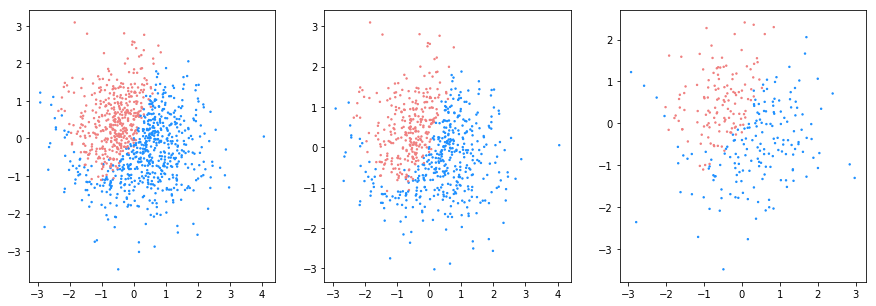

In [4]:
from matplotlib import colors as mcolors
import matplotlib.pylab as plt
%matplotlib inline
colors = ['lightcoral', 'dodgerblue']

fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)

ax[0].scatter(X.T[:,0], X.T[:,1], c=Y, cmap = mcolors.ListedColormap(colors), s = 2)
ax[1].scatter(X_train[:,0], X_train[:,1], c=y_train, cmap = mcolors.ListedColormap(colors), s = 2)
ax[2].scatter(X_test[:,0], X_test[:,1], c=y_test, cmap = mcolors.ListedColormap(colors), s = 2)

* Note que las clases de los datos cargados puede ser 0 ó 1  (variable categórica), esto se codificarán a los vectores [0 1] ó [1 0] (según corresponda) para usar una capa de salida softmax (__one hot encode__).
* De este modo, la salida de la red para un problema de clasificación de n_clases tiene tamaño n_classes, donde el índice del vector de salida de mayor valor determina la clase.

In [5]:
def one_hot_encode(y, n_classes=2):
    '''
    DESCRIPCION: Función que transforma las clases (variable categórica) en una codificación numérica.
    
    INPUT:
    
    (y)          Vector 1-darray con las clases
    (n_classes)  Cantidad de clases, por defecto 2.
    
    OUTPUT:
    (encode_y)   Vector n_classes-darray con la codificación para cada ejemplo
    
    '''
    encode_y = np.zeros((y.shape[0], n_classes), dtype=int)
    for i in range(0, y.shape[0]):
        clase = np.argmax(y[i])
        encode_y[i, y[i]] = 1
        
    return encode_y

Y_train = one_hot_encode(y_train)
Y_test = one_hot_encode(y_test)
for i in range(10):
    print('El ejemplo número', i, 'con etiqueta', y_train[i],'ha sido codificado en:', Y_train[i, :] )
    
print('Dimension etiquetas luego del encoder: (%i, %i)' %(Y_train.shape))


El ejemplo número 0 con etiqueta 1 ha sido codificado en: [0 1]
El ejemplo número 1 con etiqueta 1 ha sido codificado en: [0 1]
El ejemplo número 2 con etiqueta 1 ha sido codificado en: [0 1]
El ejemplo número 3 con etiqueta 1 ha sido codificado en: [0 1]
El ejemplo número 4 con etiqueta 0 ha sido codificado en: [1 0]
El ejemplo número 5 con etiqueta 0 ha sido codificado en: [1 0]
El ejemplo número 6 con etiqueta 1 ha sido codificado en: [0 1]
El ejemplo número 7 con etiqueta 0 ha sido codificado en: [1 0]
El ejemplo número 8 con etiqueta 1 ha sido codificado en: [0 1]
El ejemplo número 9 con etiqueta 1 ha sido codificado en: [0 1]
Dimension etiquetas luego del encoder: (700, 2)


# Tutorial de Tensorflow
El tutorial a continuación contiene lo escencial para utilizar Tensorflow, y poder utilizarlo para declarar distintas arquitecturas de red. Posteriormente pueden extender su uso a Redes Neuronales Convolucionales (CNN) y Redes Neuronales Recurrentes (RNN). Información detallada en [Basic Usage - Tensorflow](https://www.tensorflow.org/versions/r0.12/get_started/basic_usage).
* La sintaxis de Tensorflow se puede dividir en dos bloques:
    * Construcción del grafo computacional: Corresponde a un conjunto de instrucciones que definen las __operaciones__ que realiza cada nodo del grafo. Cada nodo toma cero o más tensores de entrada y produce otro tensor como salida.
    * Ejecución del grafo computacional: Corresponde a un conjunto de instrucciones que ejecutan y/o evaluan el grafo. Las operaciones se ejecutan dentro de una __sesión__, en la cual se encapsula el control y estado de Tensorflow.
    
## Construcción del grafo:

* Primero se definen los _placeholders_ o marcadores de posición, esto permite que el grafo acepte entradas externas. En este caso el conjunto de características $X$ y el de etiquetas $y$.
* Luego se debe construir la arquitectura de la red, para ello recordar que la salida de una capa _fully connected_ viene dada por,

    $$ y = \sigma(X \cdot W + b ) $$

* En este caso se ha escogido una función de activacion _Rectifier Linear Unit_ (ReLU), la cual viene dada por
    $$ \sigma(x) = \max(0, x) $$
* Más documentación en [Neural Networks](https://www.tensorflow.org/api_guides/python/nn)
* Luego se deben definir variables, cuyos valores del grafo irán cambiando de acuerdo la red vaya operando. Generalmente corresponden a los parámetros de la red (pesos y bias). Para inicializar todas las variables de un programa de Tensorflow se debe llamar al comando específico (asignado como _init_)
* Finalmente se define la función de costo, y el método de optimización.

In [6]:
#definición cantidad de neuronas:
n_hidden =  8 # Neuronas de la capa oculta
n_input = 2 # Neuronas de la capa de entrada (n_features)
n_classes = 2 # Clase A o B

#placeholder entrada
x = tf.placeholder(tf.float32, [None, n_input])

#placeholder salida
y = tf.placeholder(tf.float32, [None, n_input])

learning_rate = 0.001 # Tasa de aprendizaje
# Crear red
def multilayer_perceptron(x, weights, biases):
    # Primera capa oculta con funcion de activacion ReLU
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

# Generalmente los parámetros de la red se inicializan aleatoriamente.
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden])),
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construir el modelo
pred = multilayer_perceptron(x, weights, biases)

#función de costo
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

#optimización y entrenamiento
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(cost)

#evaluación del modelo
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

init = tf.global_variables_initializer()

## Ejecución del grafo
* Se ejecutan las variables globales inicializadas en _init_.
* Se ejecuta el entrenamiento de la red, con el conjunto de entrenamiento.
* Posteriormente se calculan las éetricas que se desplegarán, y se realiza la predicción para el conjunto de entrenamiento y prueba.

In [7]:
import time
training_epochs = 13000 # épocas de entrenamiento
display_step = 1000 # iteraciones para metrics-display

# Ejecución del grafo

with tf.Session() as sess:
    sess.run(init)
    init_time = time.time()
    # Fit all training data
    for epoch in range(training_epochs):
        sess.run(train, feed_dict={x: X_train, y: Y_train})
        #Display logs per epoch step
        if epoch % display_step == 0:
            c, train_ac = sess.run([cost, accuracy], feed_dict={x: X_train, y:Y_train})
            test_ac = accuracy.eval({x: X_test, y: Y_test})
            print("Epoch: %04d  Cost: %f  Train Accuracy: %f  Test Accuracy: %f " % ((epoch), c, train_ac, test_ac))
    training_time = time.time() - init_time
    
    pred_one_hot = sess.run(pred, feed_dict={x: X_test})
    y_pred = np.argmax(pred_one_hot, axis=1)
    
    print("Optimization Finished!")
    print('Training time: %f seconds' % training_time)

Epoch: 0000  Cost: 1.722270  Train Accuracy: 0.240000  Test Accuracy: 0.243333 
Epoch: 1000  Cost: 0.505322  Train Accuracy: 0.788571  Test Accuracy: 0.773333 
Epoch: 2000  Cost: 0.403430  Train Accuracy: 0.831429  Test Accuracy: 0.826667 
Epoch: 3000  Cost: 0.363683  Train Accuracy: 0.861429  Test Accuracy: 0.863333 
Epoch: 4000  Cost: 0.341099  Train Accuracy: 0.872857  Test Accuracy: 0.873333 
Epoch: 5000  Cost: 0.325582  Train Accuracy: 0.880000  Test Accuracy: 0.876667 
Epoch: 6000  Cost: 0.313336  Train Accuracy: 0.887143  Test Accuracy: 0.883333 
Epoch: 7000  Cost: 0.302768  Train Accuracy: 0.888571  Test Accuracy: 0.883333 
Epoch: 8000  Cost: 0.293208  Train Accuracy: 0.894286  Test Accuracy: 0.880000 
Epoch: 9000  Cost: 0.284701  Train Accuracy: 0.904286  Test Accuracy: 0.890000 
Epoch: 10000  Cost: 0.277111  Train Accuracy: 0.908571  Test Accuracy: 0.896667 
Epoch: 11000  Cost: 0.270497  Train Accuracy: 0.907143  Test Accuracy: 0.900000 
Epoch: 12000  Cost: 0.264160  Train Ac

## Matriz de confusión
Una matriz de confusión permite visualizar el desempeño de un clasificador. Esta consiste en una matriz de $(n_{classes}, n_{classes})$ donde cada elemento $(j, i)$ en la matriz cuenta la cantidad de ejemplos que han sido clasificados como $j$, cuando realmente son de la clase $i$. De este modo, en la diagonal se cuentan la cantidad de elementos que han sido correctamente clasificados.

La siguiente función permite visualizar la matriz de confusión. El calculo de la matriz de confusión se puede realizar con el modulo metrics de sklearn.

Normalized confusion matrix
             precision    recall  f1-score   support

          0       0.96      0.83      0.89       131
          1       0.88      0.98      0.93       169

avg / total       0.92      0.91      0.91       300



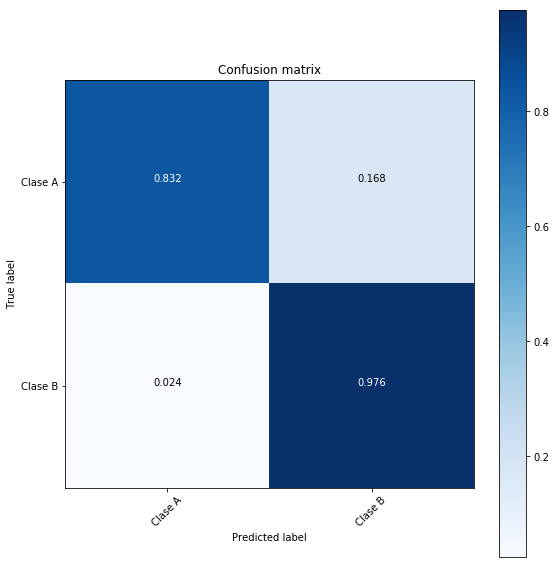

In [8]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    DESCRIPCION: Funcion que sirve para plotear una matriz de confusion.
    
    INPUT:
    (cm)         Matriz de confusion (n-darray)
    (classes)    Nombre de las clases, lista de strings con el nombre de cada clase.
    (title)      Titulo de la matriz de confusion, string.
    (cmap)       Color de la matriz de confusion

    """
    plt.figure(figsize=(8,8))
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, decimals=3)

        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_confusion_matrix(cm, ['Clase A', 'Clase B'], normalize=True)    
clc_report = classification_report(y_test, y_pred)
print(clc_report)

# Base de datos MNIST
* Se utilizará a la base de datos de [MNIST](http://yann.lecun.com/exdb/mnist/), la cual consiste en imágenes de 28x28 pixeles con digitos del 0-9 escritos a mano, cuya etiqueta (número inscrito en la imágen) es conocida.
* Cada imágen ha sido _estirada_ para formar vectores de 784 características. Además, estas se han dividido en conjunto de entrenamiento, prueba y validación (55000, 10000, y 5000 imagenes respectivamente).


# Tarea :
* Defina al menos dos arquitecturas de red para la base de datos MNIST. Se recomienda utilizar una red _fully connected_, pero también puede ser otra arquitectura no vista (como _deep_ o convolucional). Para ello ajuste cuidadosamente la cantidad de capas ocultas y la cantidad de neuronas en cada capa oculta.
* Clasifique con la red implementada el conjunto de prueba, y con la clasificación obtenida calcule la matriz de confusión, precisión, tiempo de ejecución y discuta sus resultados.
* Calcule la cantidad de parámetros entrenados en cada arquitectura.

In [9]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [10]:
# Training set
train_images = mnist.train.images
train_labels = mnist.train.labels

# Testing set
test_images = mnist.test.images
test_labels = mnist.test.labels

# Validacion set
validation_images = mnist.validation.images
validation_labels = mnist.validation.labels

print('Cantidad de caracteristicas: %i' % mnist.train.images.shape[1])
print('Cantidad de ejemplos de entrenamiento: %i' % mnist.train.images.shape[0])
print('Cantidad de ejemplos de test: %i' % mnist.test.images.shape[0])
print('Cantidad de ejemplos de validacion: %i' % mnist.validation.images.shape[0])


Cantidad de caracteristicas: 784
Cantidad de ejemplos de entrenamiento: 55000
Cantidad de ejemplos de test: 10000
Cantidad de ejemplos de validacion: 5000


Using matplotlib backend: Qt5Agg


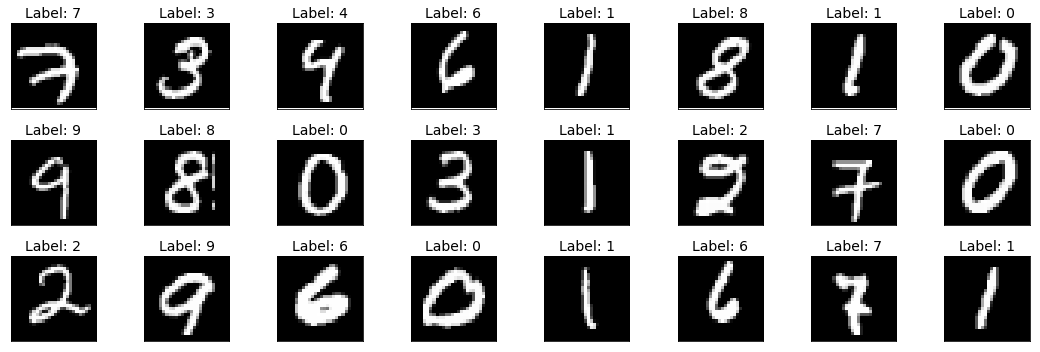

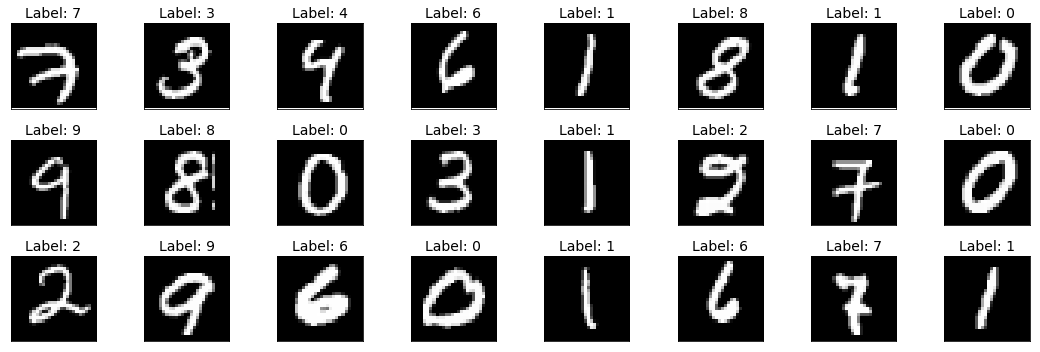

In [11]:
import matplotlib.pyplot as plt 
%matplotlib
import numpy as np

def plot_images(X,y,n):
    fig = plt.figure(figsize=(15,5))
    for i in range(0, n):
        plt.subplot(3,8,i+1)
        label = np.argmax(y[i, :])
        plt.imshow(X[i].reshape((28,28)), cmap='gray')
        plt.title(('Label: %i' %label), fontsize=14)
        plt.gca().axes.get_xaxis().set_visible(False) # borrar eje x
        plt.gca().axes.get_yaxis().set_visible(False) # borrar eje y
    plt.tight_layout()
    return fig
    
plot_images(train_images,train_labels, 24)

In [12]:
numberOfTrains = 1
accuracy_list = []

# Hiper-parametros del entrenamiento
learning_rate = 0.2
training_epochs = 25000
batch_size = 100
display_step = 500

# Hiper-parametros de la red: pruebe distintas configuraciones
n_input = 784 # Neuronas de la capa de entrada (n_features)
n_hidden_1 = 20 # Neuronas de la primera capa oculta
n_hidden_2 = 15 # Neuronas de la segunda capa oculta
n_classes = 10 # Cantidad de clases

# tf Graph input/output
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Crear modelo
def multilayer_perceptron(x, weights, biases):
    # Primera capa oculta con funcion de activacion ReLU
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

for it in range(numberOfTrains):
    # Generalmente los parámetros de la red se inicializan aleatoriamente.
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_classes]))
    }

    # Constrir el modelo
    y_mod = multilayer_perceptron(x, weights, biases) #pred

    # Definir funcion de perdida, optimizador y precision.
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_mod)) # cost
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy) # train

    # Inicializar todas las variables
    sess = tf.InteractiveSession()
    tf.global_variables_initializer().run()

    #evaluación del modelo
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_mod, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    init = tf.global_variables_initializer()


    print('- Iteration %i' % it)
    # Iniciar y entrenar el grafo (por batch)
    with tf.Session() as sess:
        sess.run(init)
        init_time = time.time()
        # Fit all training data
        for epoch in range(training_epochs):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            train_step.run(feed_dict={x: batch_xs, y: batch_ys})
            #Display logs per epoch step
#            if epoch % display_step == 0:
#                c, train_ac = sess.run([cross_entropy, accuracy], feed_dict={x: train_images, y: train_labels})
#                test_ac = accuracy.eval({x: test_images, y: test_labels})
#                print("Epoch: %04d  Cost: %f  Train Accuracy: %f  Test Accuracy: %f " % ((epoch), c, train_ac, test_ac))
        training_time = time.time() - init_time


        pred_one_hot = sess.run(y_mod, feed_dict={x: test_images})
        y_pred = np.argmax(pred_one_hot, axis=1)

        print("  - Optimization Finished!")
        print('  - Training time: %f seconds' % training_time)
        
        test_ac = sess.run(accuracy, feed_dict={x: test_images, y: test_labels})
        print('  - Test Accuracy: %f' % test_ac)
        accuracy_list.append(test_ac)

- Iteration 0
  - Optimization Finished!
  - Training time: 70.655945 seconds
  - Test Accuracy: 0.918100


In [ ]:
import tensorflow as tf

# Hiper-parametros del entrenamiento
learning_rate = 1e-4
training_epochs = 1000
batch_size = 50
display_step = 500

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_conv))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    init_time = time.time()
    for i in range(training_epochs):
        batch = mnist.train.next_batch(batch_size)
        train_step.run(feed_dict={x: batch[0], y: batch[1], keep_prob: 0.5})
        if i%display_step == 0:
            test_ac = accuracy.eval(feed_dict={x: batch[0], y: batch[1], keep_prob: 1.0})
            print("  - Epoch: %i; Test accuracy: %g"% (i, test_ac))
#            print("Epoch: %04d  Cost: %f  Train Accuracy: %f  Test Accuracy: %f " % ((i), c, train_ac, test_ac))
    training_time = time.time() - init_time
        
    print("  - Optimization Finished!")
    print('  - Training time: %f seconds' % training_time)

    print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0}))

  - Epoch: 0; Test accuracy: 0.08
  - Epoch: 500; Test accuracy: 0.98
  - Optimization Finished!
  - Training time: 231.490005 seconds
test accuracy 0.9669


__Compare las arquitecturas elegidas evaluando su clasificación en base a la matriz de confusión, tiempos de entrenamiento, precisión y discuta sus resultados.__ 

* Si el entrenamiento es muy lento, puede considerar dos cosas para acelerar:

__Opción 1)__ Aplicar una reducción de dimensionalidad, como _Principal Components Analisys_ (incluido más abajo) o [T-SNE](https://lvdmaaten.github.io/tsne/.)





In [ ]:
from sklearn.decomposition import PCA
n_components = 2 # Componentes principales, escoja FUNDADAMENTE.
pca = PCA(n_components=n_components)
pca.fit(train_images)
Xp_train = pca.transform(train_images)
Xp_test = pca.transform(test_images)
print("Dim  originales :" ,train_images.shape, test_images.shape, train_labels.shape , test_labels.shape)
print("Dim despues PCA :", Xp_train.shape, Xp_test.shape )

In [ ]:
plt.figure(figsize=(10,10))
classes = np.argmax(train_labels, axis=1)
n_classes = 10
for i in range(n_classes):
    unit_class = np.where(classes == i)[0]
    plt.scatter(Xp_train[unit_class, 0], Xp_train[unit_class, 1], label='Digito '+str(i))
    plt.legend()
    plt.grid(True)

__Opción 2)__ Entrenar por mini batches en cada época. Un batch es un subconjunto de  elementos de la base de datos de entrenamiento, idealmente cada mini batch es distinto del anterior. Por suerte, mnist trae incorporado un método para adquirir secuencialmente cada batch de tamaño n_batch.
    
            batch = mnist.train.next_batch(n_batch, shuffle=True)
            X_train = batch[0]
            Y_train = batch[1]